# Übungsblatt 2 - Programmieraufgaben (20 Punkte)
BA-INF 153: Einführung in Deep Learning für Visual Computing

**Deadline - 03.05.2023 via eCampus**

**Tutoren:**
 * Alina Pollehn - s6aapoll@uni-bonn.de
 * Felix Göhde - s6fegoeh@uni-bonn.de
 
**Übungsgruppenleitung:**
 * Jan Müller - muellerj@cs.uni-bonn.de


## Imports und Visualisierung

Zur Visualisierung verwenden wir hier [Matplotlib](https://matplotlib.org/). Da wir bisher nur PyTorch und Jupyter in der Conda Kursumgebung installiert haben, muss die Matplotlib noch installiert werden. Dies sollte automatisch beim ersten Ausführen der nächsten Zelle passieren. Es kann notwendig sein Jupyter oder die IDE ihrer Wahl neu zu starten damit die Installation richtig erkannt wird. 

In [1]:
#Armin Schuster, Rouy Alfahel, Ilia Mirkis

In [2]:
import torch
import torch.nn as nn
import numpy as np
import math
try:
    import matplotlib.pyplot as plt
except ModuleNotFoundError:
    # Matplotlib ist noch nicht installiert in der aktuellen Umgebung und 
    # wird mit Hilfe von conda installiert. Dies kann einen Moment dauern.
    import sys
    %conda install --yes --prefix {sys.prefix} matplotlib
    import matplotlib.pyplot as plt

from visualization import (
    create_contourline_figure,
    scatter_path_in_figure,
    create_losscurve_figure,
    show_figure
)

Damit wir uns um die Details der Visualisierung so wenig Gedanken wie nötig machen müssen haben wir die folgenden Funktion gegeben:

 * ```create_contourline_figure(fn : Callable, log_scale : bool)``` erzeugt eine Konturlinienfigur für eine gegebene Funktion fn. Die Funktion fn muss einen Tensor der Form $(n,2)$ akzeptieren und einen Tensor der Form $(n,)$ mit Skalarwerten zurückgeben. Die Option log_scale bestimmt, ob die Z-Achse logarithmisch skaliert werden soll oder nicht. Die Funktion gibt ein matplotlib.pyplot.Figure-Objekt zurück, das die Konturlinienfigur enthält.

 * ```scatter_path_in_figure(fig : plt.Figure, path : torch.Tensor, name : str)``` nimmt eine plt.Figure-Instanz, einen Pfad als torch.Tensor und einen Namen als String als Parameter entgegen und gibt eine plt.Figure-Instanz zurück. Die Funktion zeichnet den Pfad als Scatterplot in die übergebene Figur ein und beschriftet ihn mit dem Namen. Die Funktion ist nützlich, um mehrere Pfade in einer einzigen Figur zu vergleichen.

 * ```create_losscurve_figure(loss_values : list[float])``` erstellt eine Grafik, die den Verlustwert (loss value) in Abhängigkeit von der Anzahl der Trainingsiterationen zeigt. Die Funktion nimmt eine Liste von Gleitkommazahlen als Eingabe, die die Verlustwerte für jede Iteration enthalten. Die Funktion gibt ein plt.Figure-Objekt zurück, das die Grafik darstellt.

 * ```show_figure(fig : plt.Figure)``` zeigt eine matplotlib-Figur an. Die Figur wird als Parameter übergeben und muss vom Typ plt.Figure sein.

## Minimum der Rosenbrock Function


Die Rosenbrock-Funktion ist eine differenzierbare, nicht konvexe Funktion, die häufig zum Vergleich von unterschiedlichen Optimierungsalgorithmen verwendet wird. Für Parameter $a,b$ ist die Funktion definiert als

\begin{equation}
f(x,y) = (a-x)^2+b(y-x^2)^2.
\end{equation}

**Aufgabe (2 Punkte):** Vervollständigen Sie die Funkion ```rosenbrock(...)``` in der untenstehenden Zelle so, dass sie den Funktionswert $f_{a,b}(x,y)$ zurückgibt. Gehen Sie davon aus, dass der Tensor xy die Form $[2,]$ oder $[n,2]$ haben kann und verändern Sie nicht die Definition der Funktionsargumente.

In [3]:
def rosenbrock(xy : torch.Tensor, a : float = 1., b : float = 100.) -> torch.Tensor:
    if xy.dim() == 1:
        return (a - xy[0])**2 + b * (xy[1] - xy[0]**2)**2
    return (a - xy[::, 0])**2 + b * (xy[::, 1] - xy[::, 0]**2)**2

Führen Sie nun die nächste Codezelle aus um Ihre Implementierung der Rosenbrock Funktion zu test. Die Funktion der Konturlinien der Rosenbrock Funktion anzeigen lassen. Diese sollten wie folgt aussehen:

![Kontourlinien der Rosenbrock Funktion mit a = 1 und b = 100 (lograithmisch)](./rosenbrock.png)

/home/luty/proga/Introduction-to-deep-learning-/U2/visualization.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


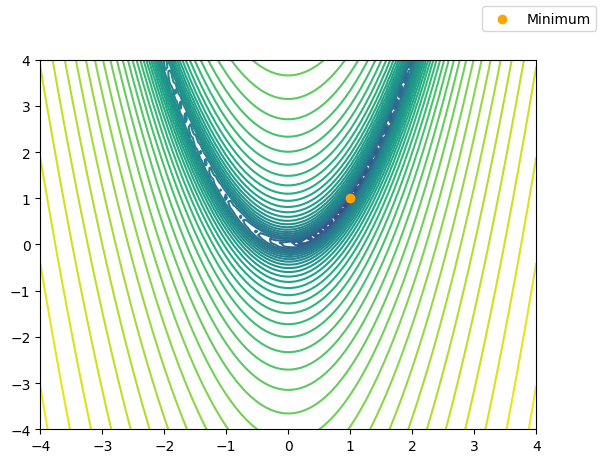

In [4]:
fig = create_contourline_figure(rosenbrock, True)
show_figure(fig)

### Automatische Differenzierung in PyTorch

Eine zentrale Funktion von PyTorch ist die automatische Berechnung von Ableitungen. Die Berechnung einer Ableitung in PyTorch kann in drei Schritte aufgeteilt werden: 

1. Wir erzeugen Tensoren, die wir als Eingabe für unsere Berechnungen verwenden und für die wir später den Gradient berechnet werden wollen. Bevor wir eine Tensor zum ersten Mal in einer Berechnung verwenden müssen wir PyTorch mitteilen welche, dass wir für diesen Tensor einen Gradienten berechnen wollen. Dafür hat jeder Tensor hat das boolean Attribute [torch.Tensor.requires_grad](https://pytorch.org/docs/stable/generated/torch.Tensor.requires_grad.html) welches angibt ob für diesen Tensor der Gradient ausgewertet werden soll. Dieses Attribut kann entweder beim Erstellen des Tensors oder nachträglich wie folgt festgelegt werden:

```python
        th_tensor = torch.ones([2], requires_grad = True) # Beim Erzeugen eines Tensors
        th_tensor.requires_grad_(True) # Nach dem der Tensor schon erzeugt wurde.
```

2. Wir können beliebige mathematische Operationen auf dem Tensor ausführen, um eine Ausgabe zu erhalten. PyTorch wird automatisch einen Berechnungsgraphen erstellen, der die Abhängigkeiten zwischen den Tensoren und den Operationen speichert (dazu mehr auf dem nächsten Übungsblatt). 

    * Die Berechnungen dürfen ausschließlich PyTorch Tensoren und Funktionen verwenden. Operatoren ```+,-,*,/,**``` etc., die für den Tensor überladen sind, sind in den PyTorch Funktionen eingeschlossen.  Ebenfalls sind Operationen zwischen skalaren Konstanten und Tensoren wie zum Beispiel ```y = 2.0*x``` sind zulässig.

    * Eine Einschränkung dieser Methode ist, dass wir nur den Gradienten eines skalaren Werts (eine Zahl) berechnen können. Also muss das Ergebnis ein Tensor sein, der nur einen Skalar enthält. d.h. die Form des resultierenden Tensors muss $()$ oder $(1)$ sein.

3. Um den Gradienten der Ausgabe in Bezug auf den Eingangstensor zu berechnen, müssen wir die Methode [torch.Tensor.backward()](https://pytorch.org/docs/stable/generated/torch.Tensor.backward.html) aufrufen, die den Gradienten der Berechnung in dem Attribut [torch.Tensor.grad](https://pytorch.org/docs/stable/generated/torch.Tensor.grad.html) speichert.

Eine weitere Einschränkung ist, dass wir die Methode `backward()` nur einmal pro Berechnungsgraph aufrufen können, es sei denn, wir setzen den Parameter `retain_graph=True`. Andernfalls wird der Graph nach dem Aufruf gelöscht, um Speicherplatz zu sparen.

**Aufgabe (1 Punkt):** Stellen Sie sicher, dass Ihre Rosenbrockfunktion nur PyTorch Funktionen verwendet und passen Sie Ihre Implementierung ggf. an. Folgen Sie den drei Schritten um die Ableitung der Rosenbrock Funktion an der Stelle $(-3,-3)$ zu berechnen und auszugeben. Wenn Ihre Implementierung korrekt ist, sollten Sie die Ableitungen $df/dx = 14408$ uns $df/dy=-2400$ im grad-Attribute stehen. 

In [5]:
xy = torch.full([2], -3.)
# Begin Ihrer Lösung:
xy.requires_grad_(True)
rosenbrock(xy).backward()
print(xy.grad)

tensor([-14408.,  -2400.])


### Gradientabstieg in PyTorch

Nachdem wir nun in der Lage sind, mit Hilfe von PyTorch die Ableitung der Rosenbrock-Funktion an einem Punkt $(x,y)$ zu berechnen, sind wir unserem Ziel, ein Minimum der Rosenbrock-Funktion zu finden, einen Schritt näher gekommen. Alles, was wir jetzt noch benötigen, ist ein Algorithmus um ein Update der Position durch Gradientabstieg durchzuführen. 

Jeder Optimierungsalgorithmus in PyTorch erbt von der Klasse [torch.optim.Optimizer](https://pytorch.org/docs/stable/optim.html#torch.optim.Optimizer) und implementiert die essentiellen Funktionen:

 * Die Methode [torch.optim.Optimizer.step()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.step.html) aktualisiert die Parameter des Modells, basierend auf den berechneten Gradienten.

 * Die Methode [torch.optim.Optimizer.zero_grad()](https://pytorch.org/docs/stable/generated/torch.optim.Optimizer.zero_grad.html) setzt alle Gradienten der Parameter des Optimizers auf Null. Dies ist nützlich, um die Gradientenakkumulation zu vermeiden, die bei mehreren Aufrufen von backward() ohne einen Optimierungsschritt auftreten kann. Die zero_grad() Funktion sollte vor jedem Optimierungsschritt aufgerufen werden, um sicherzustellen, dass die Gradienten korrekt berechnet werden.


In der Vorlesung haben wurden vier unterschiedliche Gradient Descent Optimierer vorgestellt, die alle in PyTorch implementiert sind:

 1. [torch.optim.SGD](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html) - einfacher (stochastischer) Gradientenabstieg
 2. [torch.optim.Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html) - AdaGrad Algorithmus
 3. [torch.optim.RMSProp](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html) - RMSProp Algorithmus
 4. [torch.optim.Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html) - Adam Algorithmus

Der Konstruktor dieser Optimierer erwartet ein Iterable Objekt, das die Parameter enthält, die wir optimieren wollen - also zum Beispiel eine Liste von Tensoren. Zusätzlich akzeptiert jeder Optimierer eine Lernrate als Argument. Hier ist ein Beispiel:
```python
    optimizer = torch.optim.SGD([tensor], lr=0.01)
```

**Aufgabe (2 Punkte):** Vervollständigen Sie die Funktion ```minimize``` in der nächsten Codezelle. Die Funktion soll den Funktionswert der Rosenbrock-Funktion an der Stelle ```xy``` auswerten und die Ableitung des Funktionswerts bzgl. des Tensors `xy` bestimmen. Verwenden Sie anschließend den ```optimizer``` um einen Gradientabstieg-Schritt durchzuführen und die Gradienten der Tensoren auf Null zurückzusetzen.

In [6]:
def minimize(xy : torch.Tensor, optimizer : torch.optim.Optimizer, steps : int = 1000) -> torch.Tensor:
    path = torch.empty(size=[steps,2])
    for idx in range(steps):
        path[idx] = xy.detach().clone()
        # Begin Ihrer Lösung
        optimizer.zero_grad()
        rosenbrock(xy).backward()
        optimizer.step()
        # Ende Ihrer Lösung
    return path

**Aufgabe (4 Punkte):** Verwenden Sie die Optimierer SGD, Adagrad, RMSProp und Adam, um das Minimum der Rosenbrockfunktion durch Gradientabstieg zu finden. Experimentieren Sie dabei mit der Lernrate und der Anzahl an Iterationen, um dem tatsächlichen Minimum der Funktion möglichst nah zu kommen. Die Optimierung soll jeweils vom Punkt $(-3,-3)$ starten. Verwenden Sie dabei die Funktion ```minimize``` und erstellen einen Kontourplot der Rosenbrock-Funktion, in dem auch die Pfade eingezeichnet sind, die durch den Gradientenabstieg entstanden sind.

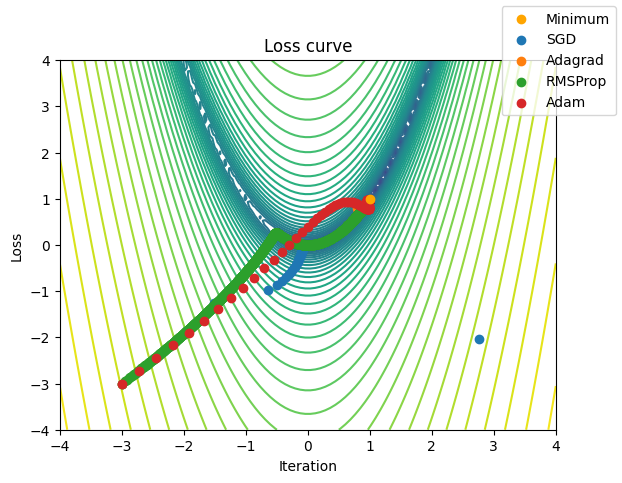

In [7]:
xy = nn.Parameter(torch.full([2], -3.))

# Begin Ihrer Lösung:
xy.requires_grad_(True)
xy_Adagrad = xy.detach().clone().requires_grad_(True)
xy_RMSProp = xy.detach().clone().requires_grad_(True)
xy_Adam = xy.detach().clone().requires_grad_(True)

opt = torch.optim.SGD([xy], lr = 0.0004)
opt_Adagrad = torch.optim.Adagrad([xy_Adagrad], lr = 3.8)
opt_RMSProp = torch.optim.RMSprop([xy_RMSProp], lr = 0.005)
opt_Adam = torch.optim.Adam([xy_Adam], lr = 0.28)

res = minimize(xy, opt, 10000)
res_Adagrad = minimize(xy_Adagrad, opt_Adagrad, 5000)
res_RMSProp = minimize(xy_RMSProp, opt_RMSProp, 4000)
res_Adam = minimize(xy_Adam, opt_Adam, 2000)

rosenbrock_figure = create_contourline_figure(rosenbrock, log_scale = True)
scatter_path_in_figure(rosenbrock_figure, res, "SGD")
scatter_path_in_figure(rosenbrock_figure, res_Adagrad, "Adagrad")
scatter_path_in_figure(rosenbrock_figure, res_RMSProp, "RMSProp")
scatter_path_in_figure(rosenbrock_figure, res_Adam, "Adam")

show_figure(rosenbrock_figure)

## Polynom Fitting with PyTorch

Bevor wir Neuronale Netzwerke mit Gradientenabstieg optimieren wollen wir uns zunächst die grundlegenden Schritte die in fast allen Trainingsroutinen zu finden sind am Beispiel einer einfachen Funktionsklasse anschauen. Dafür ist uns eine einfache, aber langsame PyTorch Implementierung eines Polynoms 

$
P(x,y) = \sum_{i,j} c_{ij} \cdot x^i \cdot y^j
$

mit Koeffizienten $c_{ij}$ gegeben. Das folgende Beispiel zeigt wie wir ein Polynom $P(x,y)$ als Instanz der Klasse `Polynom2D` erzeugen und den Funktionswert an der Stelle `xy` berechnen.

```python
    xy = torch.full([2], -3)
    polynom = Polynom2D(degree=4)
    z = polynom(xy)
```

In [8]:
class Polynom2D(nn.Module):

    def __init__(self, degree : int = 2) -> None:
        super().__init__()
        self.coeffs = nn.Parameter(
            torch.randn(degree+1, degree+1)
        )

    def forward(self, xy : torch.Tensor) -> torch.Tensor:
        x, y = xy.split(1, dim=-1)
        values = torch.zeros_like(x)
        for (j,i) in np.ndindex(self.coeffs.shape):
            values += (self.coeffs[i, j] * (x**i) * (y**j))
        return values

**Aufgabe: (1 Punkt)** Erstellen Sie eine Instanz der Klasse `Polynom2D` und erstellen Sie einen Plot der Kontourlinien des Polynoms mit normalverteilen Koeffizienten.

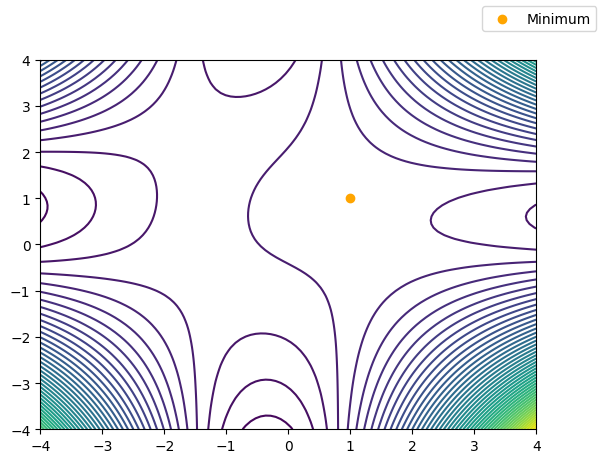

In [9]:
# Begin Ihrer Lösung:
instance = Polynom2D()
fig = create_contourline_figure(instance.forward)
show_figure(fig)

Damit wir unser Polynom an die uns unbekannte Funktion fitten können, laden wir einen Datensatz der Funktionswerte einer uns unbekannten Funktion enthält, die wir mit unserem Polynom darstellen wollen. Die Daten bestehen aus Trainingsdaten ```train_points```, welche zwei-dimensionale Punkte enthält, an denen wir die Funktionswerte `train_values` gegeben haben. Zusätzlich sind auch noch Punkte und Funktionswerte in `test_points` und `test_values` in dem Datensatz enthalten. Diese sollen nur zur Evaluierung des gefitteten Polynoms verwendet werden.

In [10]:
data_dict = torch.load("./trainingsdata.ckpt")
train_points, train_values = data_dict["train"]
test_points, test_values = data_dict["test"]

**Aufgabe (1 Punkt):** Berechnen Sie den Mean Absolute Error zwischen den gegebenen Funktionswerten in ```test_values``` und den Funktionswerten die das zufällig initialisierte Polynom an den Punkte im Tensor ```test_points``` annimmt.

In [11]:
polynom = Polynom2D()
# Begin Ihrer Lösung:
MAE_loss = nn.L1Loss()
loss_value = MAE_loss(polynom.forward(test_points), test_values)
print(loss_value.item())

827.4906005859375


**Aufgabe (2 Punkte):** Vervollständigen Sie die Funktion ```train``` so dass im "Forward step" die Funktionswerte des Modells an den Punkten in ```points``` ausgewertet werden und anschließend der MAE zwischen Funktionswerten und Werten in ```gt_values``` berechnet wird. Im "Backward step" soll dann die Ableitung des MAE ausgewertet werden, die Parameter des Models mit Gradientenanstieg angepasst werden und die Gradienten wieder auf 0 zurückgesetzt werden.

In [12]:
def train(model : nn.Module, optim : torch.optim.Optimizer, data : tuple[torch.Tensor, torch.Tensor], num_steps : int = 1000) -> list[float]:
    points, gt_values = data
    loss_fn = nn.L1Loss()
    loss_curve = []
    for _ in range(num_steps):

        # Forward step
        # Ihre Lösung hier
        model_prediction = model.forward(test_points)
        loss = loss_fn(model_prediction, test_values)
        
        # Backward step
        # Ihre Lösung hier
        optim.zero_grad()
        loss.backward()
        optim.step()

        # Logging
        loss_curve.append(loss.item())

    return loss_curve

**Aufgabe (6 Punkte)** Verwenden Sie die Funktion ```train``` um die Koeffizienten des Polynoms mit Gradientenabstieg mit Hilfe der Trainingsdaten `train_points, train_values` so zu optimieren, dass der MAE auf den Trainingsdaten minimiert wird. Erstellen Sie eine Figure der resultierenden Zielfunktionskurve, eine Figure der Kontourlinien des gefitteten Polynoms und berechnen Sie den MAE auf den Testdaten. Wählen Sie einen passenden Optimierer, begründen Sie Ihre Wahl und variieren Sie den Grad des Polynoms zu 2,4 und 6. Erklären Sie Ihre Beobachtungen.

**Hinweis:** Sie können einen Iterator über die Parameter einer Instanz der Klasse Polynom mit der Member-Funktion ```Polynom2D.parameters()``` erhalten. Die Klasse Polynom2D erbt diese Funktion von ```torch.nn.Module```.

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE on train-data: 179.52999877929688
MAE on test-data: 239.83029174804688


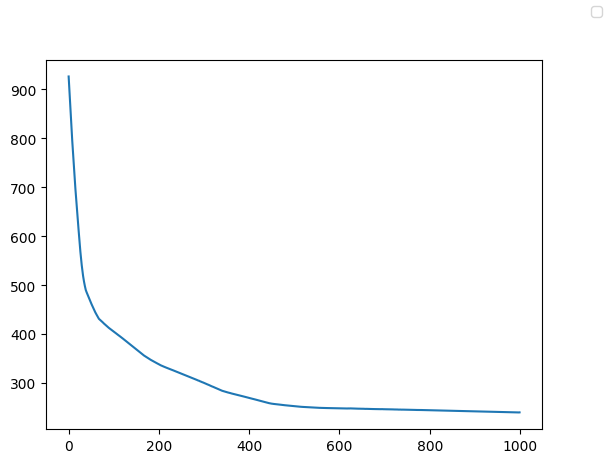

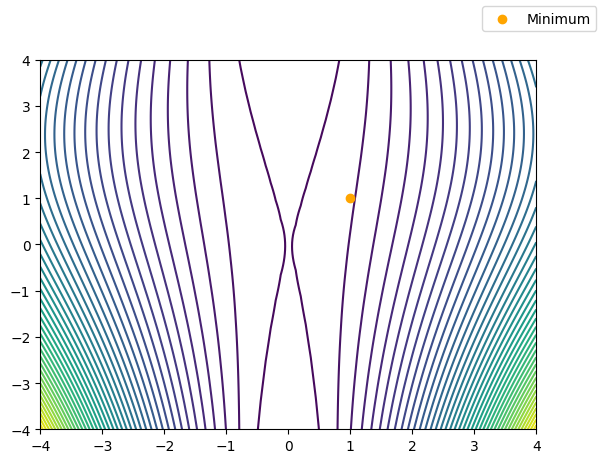

In [13]:
# Begin Ihrer Lösung: polynom degree = 2
polynom = Polynom2D(degree=2)
loss_curve = train(polynom, torch.optim.Adam(polynom.parameters(), lr = 0.3), [train_points, train_values], 1000)
show_figure(create_losscurve_figure(loss_curve))
show_figure(create_contourline_figure(polynom))
loss_fn = nn.L1Loss()
print("MAE on train-data:", loss_fn(polynom.forward(train_points), train_values).item())
print("MAE on test-data:", loss_fn(polynom.forward(test_points), test_values).item())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE on train-data: 22.20882797241211
MAE on test-data: 29.286237716674805


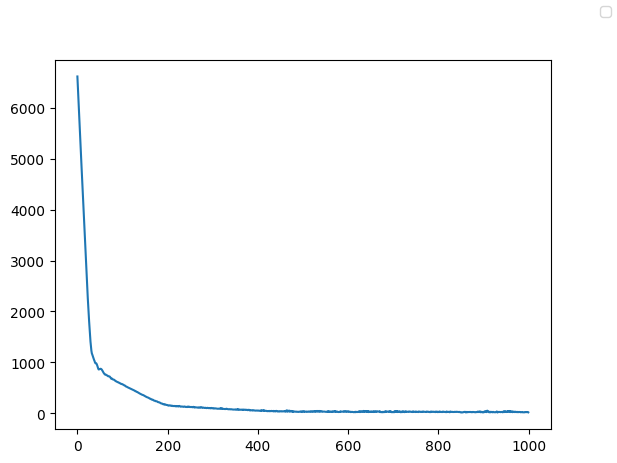

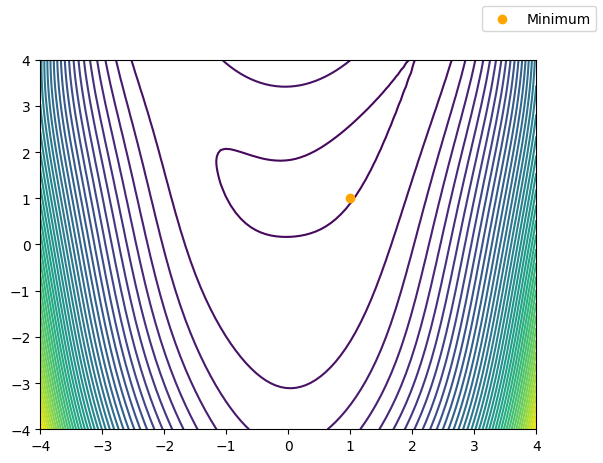

In [14]:
#polynom degree = 4
polynom = Polynom2D(degree = 4)
loss_curve = train(polynom, torch.optim.Adam(polynom.parameters(), lr = 0.03), [train_points, train_values], 1000)
show_figure(create_losscurve_figure(loss_curve))
show_figure(create_contourline_figure(polynom))
loss_fn = nn.L1Loss()
print("MAE on train-data:", loss_fn(polynom.forward(train_points), train_values).item())
print("MAE on test-data:", loss_fn(polynom.forward(test_points), test_values).item())

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


MAE on train-data: 8334.2314453125
MAE on test-data: 21400.404296875


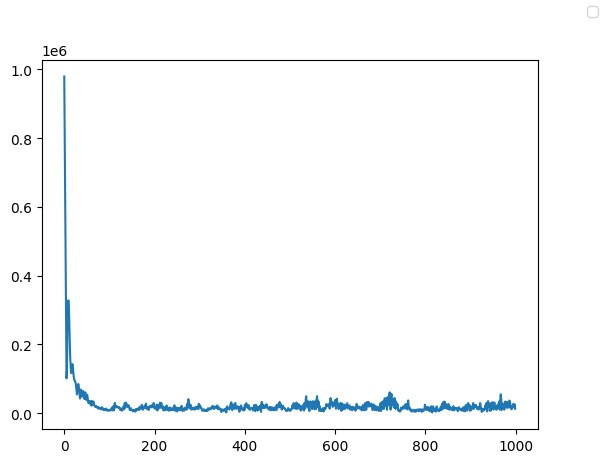

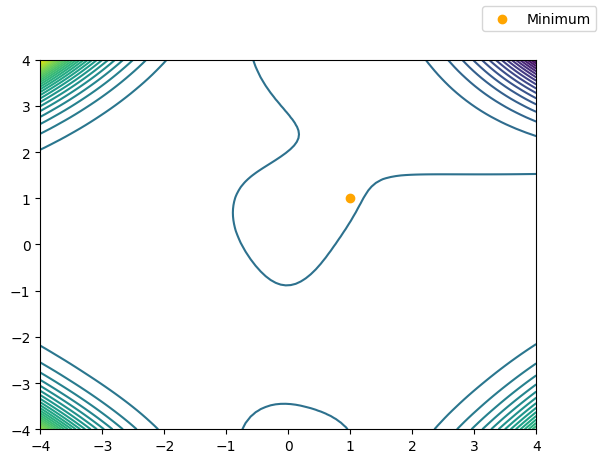

In [15]:
#polynom degree = 6
polynom = Polynom2D(degree = 6)
loss_curve = train(polynom, torch.optim.Adam(polynom.parameters(), lr = 0.15), [train_points, train_values], 1000)
show_figure(create_losscurve_figure(loss_curve))
show_figure(create_contourline_figure(polynom))
loss_fn = nn.L1Loss()
print("MAE on train-data:", loss_fn(polynom.forward(train_points), train_values).item())
print("MAE on test-data:", loss_fn(polynom.forward(test_points), test_values).item())

Explore underfitting, overfitting und gute generalisierung mit einem Polynom von grad 2, 4 und 6?

In [16]:
# Grad 2 shows Underfitting
# Grad 4 has good capacity -> good generalization
# Grad 6 shows Overfitting